In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [6]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [7]:
df_2020 = pd.read_csv('../../dobrano_2020_pre_preprocessado.csv', sep=';', low_memory=False, encoding='latin1')
df_2020.shape

(454432, 17)

In [8]:
df_2020.head()

,idade,sexo,raca_cor,escolaridade,local_ocorrencia,teve_assistencia_medica,dia_nasc,mes_nasc,ano_nasc,dia_obito,mes_obito,ano_obito,estado,grupo_causa_basica,causa_basica,ocupacao,grupo_ocupacao
0,68.0,M,BRANCA,EF_I,DOMICILIO,NAO,10,5.0,1951.0,25,1,2020,MG,Causas mal definidas e desconhecidas de mortal...,Outras causas mal definidas e as não especific...,NaN,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...
1,53.0,M,PRETA,EF_I,DOMICILIO,NAO,16,3.0,1966.0,25,1,2020,MG,Causas mal definidas e desconhecidas de mortal...,Outras causas mal definidas e as não especific...,Trabalhador agropecuário em geral,"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA P..."
2,82.0,F,BRANCA,EF_I,HOSPITAL,NaN,10,7.0,1937.0,14,1,2020,MG,Outras doenças dos intestinos,"Doença diverticular do intestino, de localizaç...",NaN,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...
3,73.0,F,BRANCA,EF_I,HOSPITAL,SIM,2,11.0,1946.0,20,1,2020,MG,Outras doenças do aparelho respiratório,Insuficiência respiratória aguda,NaN,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...
4,60.0,M,BRANCA,SUPERIOR_C,HOSPITAL,SIM,12,9.0,1959.0,26,1,2020,MG,Outras doenças bacterianas,Septicemia não especificada,Professor da educação de jovens e adultos do ...,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES ...


#### TRANSFORMANDO DADOS EM NUMÉRICOS

In [9]:
df_2020['raca_cor'] = df_2020['raca_cor'].replace(['BRANCA', 'PRETA', 'AMARELA', 'PARDA', 'INDIGENA'], [1, 2, 3, 4, 5])

In [10]:
df_2020['escolaridade'] = df_2020['escolaridade'].replace(
                                          ['SEM', 'EF_I', 'EF_II', 'EM', 'SUPERIOR_I', 'SUPERIOR_C', 'I'],
                                        [0, 1, 2, 3, 4, 5, 9]
                                         )

In [11]:
df_2020['local_ocorrencia'] = df_2020['local_ocorrencia'].replace(['HOSPITAL', 'OES', 'DOMICILIO', 'VIAP', 'OUTROS', 'I'],
                                            [1, 2, 3, 4, 5, 9]
                                         )

In [12]:
df_2020['teve_assistencia_medica'] = df_2020['teve_assistencia_medica'].replace(['SIM', 'NAO', 'I'], [1, 2, 9]
                                             )

In [13]:
df_2020['sexo'] = df_2020['sexo'].replace(['M', 'F', 'I'], [1, 2, 0]) 

##### REORGANIZANDO DESCRIÇÕES DOS GRUPOS DOS CIDS E DAS OCUPAÇÕES

In [14]:
df_cid_grupos = pd.read_csv('../../CID-10-GRUPOS.csv', header=0, sep=';', encoding='latin1')
# df_cid_grupos.head()

df_cid_grupos = df_cid_grupos.drop(columns=['Unnamed: 0'])

In [15]:
df_cid_grupos.head()

,CATINIC,CATFIM,DESCRICAO,DESCRABREV
0,A00,A09,Doenças infecciosas intestinais,Doenças infecciosas intestinais
1,A15,A19,Tuberculose,Tuberculose
2,A20,A28,Algumas doenças bacterianas zoonóticas,Algumas doenças bacterianas zoonóticas
3,A30,A49,Outras doenças bacterianas,Outras doenças bacterianas
4,A50,A64,Infecções de transmissão predominantemente sexual,Infecções de transmissão predominantemente sexual


In [16]:
cid_grupos = [i for i in range(df_cid_grupos.shape[0])]

In [17]:
df_cid_grupos['VALOR'] = cid_grupos

In [18]:
df_ocup_grupo = pd.read_csv('../../Downloads/CBO2002_Grande_Grupo.csv', header=0, sep=';', encoding='latin1')

In [19]:
df_ocup_grupo.head()

,CODIGO,TITULO
0,0,"MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEI..."
1,1,"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTE..."
2,2,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES ...
3,3,TÉCNICOS DE NIVEL MÉDIO ...
4,4,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS ...


In [20]:
df_ocup_grupo.append({'TITULO': 'SEM OCUPAÇÃO', 'CODIGO': str(df_ocup_grupo.shape[0])}, ignore_index=True)

,CODIGO,TITULO
0,0,"MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEI..."
1,1,"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTE..."
2,2,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES ...
3,3,TÉCNICOS DE NIVEL MÉDIO ...
4,4,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS ...
5,5,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ..."
6,6,"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA P..."
7,7,TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...
8,8,TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...
9,9,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...


In [21]:
ocup_grupos = [i for i in range(df_ocup_grupo.shape[0])]
# ocup_grupos.append(len(ocup_grupos) + 1)

In [22]:
df_ocup_grupo['VALOR'] = ocup_grupos

In [23]:
def group_ocup(row, grupo):
    grupo.loc[(grupo.grupo_ocupacao == row.TITULO),
             ['grupo_ocupacao']] = row.VALOR

In [24]:
df_ocup_grupo.apply(group_ocup, grupo=df_2020, axis='columns')

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
9    None
dtype: object

In [25]:
def categoria_cid(row, cids):
    cids.loc[(cids.grupo_causa_basica == row.DESCRICAO),
             ['grupo_causa_basica']] = row.VALOR

In [26]:
df_cid_grupos.apply(categoria_cid, cids=df_2020, axis='columns')

0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
30     None
31     None
32     None
33     None
34     None
35     None
36     None
37     None
38     None
39     None
40     None
41     None
42     None
43     None
44     None
45     None
46     None
47     None
48     None
49     None
50     None
51     None
52     None
53     None
54     None
55     None
56     None
57     None
58     None
59     None
60     None
61     None
62     None
63     None
64     None
65     None
66     None
67     None
68     None
69     None
70     None
71     None
72     None
73     None
74     None
75     None
76     None
77     None
78     None
79     None
80     None
81     None
82     None
83  

In [27]:
df_2020.head()

,idade,sexo,raca_cor,escolaridade,local_ocorrencia,teve_assistencia_medica,dia_nasc,mes_nasc,ano_nasc,dia_obito,mes_obito,ano_obito,estado,grupo_causa_basica,causa_basica,ocupacao,grupo_ocupacao
0,68.0,1,1.0,1.0,3,2.0,10,5.0,1951.0,25,1,2020,MG,201,Outras causas mal definidas e as não especific...,NaN,9
1,53.0,1,2.0,1.0,3,2.0,16,3.0,1966.0,25,1,2020,MG,201,Outras causas mal definidas e as não especific...,Trabalhador agropecuário em geral,6
2,82.0,2,1.0,1.0,1,NaN,10,7.0,1937.0,14,1,2020,MG,117,"Doença diverticular do intestino, de localizaç...",NaN,9
3,73.0,2,1.0,1.0,1,1.0,2,11.0,1946.0,20,1,2020,MG,111,Insuficiência respiratória aguda,NaN,9
4,60.0,1,1.0,5.0,1,1.0,12,9.0,1959.0,26,1,2020,MG,3,Septicemia não especificada,Professor da educação de jovens e adultos do ...,2


#### ATRIBUINDO CÓDIGO DOS ESTADOS AS SUAS RESPECTIVAS UFs

In [28]:
data_estados = pd.read_csv('../../Downloads/estados_ibge.csv', sep=';', header=0, encoding='latin1')

In [29]:
data_estados.head()

,CODIGO,UF,ESTADO
0,12,AC,Acre
1,27,AL,Alagoas
2,13,AM,Amazonas
3,16,AP,Amap
4,29,BA,Bahia


In [30]:
uf = pd.Series(data_estados['UF'].astype('str'))
uf = uf.values

In [31]:
df_2020['estado'] = df_2020['estado'].replace(data_estados['UF'].values, data_estados['CODIGO'].values)

In [32]:
df_2020.head()

,idade,sexo,raca_cor,escolaridade,local_ocorrencia,teve_assistencia_medica,dia_nasc,mes_nasc,ano_nasc,dia_obito,mes_obito,ano_obito,estado,grupo_causa_basica,causa_basica,ocupacao,grupo_ocupacao
0,68.0,1,1.0,1.0,3,2.0,10,5.0,1951.0,25,1,2020,31,201,Outras causas mal definidas e as não especific...,NaN,9
1,53.0,1,2.0,1.0,3,2.0,16,3.0,1966.0,25,1,2020,31,201,Outras causas mal definidas e as não especific...,Trabalhador agropecuário em geral,6
2,82.0,2,1.0,1.0,1,NaN,10,7.0,1937.0,14,1,2020,31,117,"Doença diverticular do intestino, de localizaç...",NaN,9
3,73.0,2,1.0,1.0,1,1.0,2,11.0,1946.0,20,1,2020,31,111,Insuficiência respiratória aguda,NaN,9
4,60.0,1,1.0,5.0,1,1.0,12,9.0,1959.0,26,1,2020,31,3,Septicemia não especificada,Professor da educação de jovens e adultos do ...,2


In [33]:
df_2020 = df_2020.drop(columns=['causa_basica', 'ocupacao'])

#### SEPRANDO DATASETS

In [34]:
df_2020 = df_2020[:1000]

In [35]:
df_2020 = df_2020.loc[df_2020['grupo_causa_basica'].notnull()]

In [36]:
df_2020.isnull().sum()

idade                        0
sexo                         0
raca_cor                    38
escolaridade                93
local_ocorrencia             0
teve_assistencia_medica    221
dia_nasc                     0
mes_nasc                    21
ano_nasc                    21
dia_obito                    0
mes_obito                    0
ano_obito                    0
estado                       0
grupo_causa_basica           0
grupo_ocupacao             126
dtype: int64

In [37]:
df_2020 = df_2020.loc[df_2020.teve_assistencia_medica.notnull()]

In [38]:
df_2020 = df_2020.loc[df_2020.raca_cor.notnull()]

In [39]:
df_2020 = df_2020.loc[df_2020.escolaridade.notnull()]

In [40]:
df_2020 = df_2020.loc[df_2020.mes_nasc.notnull()]

In [41]:
df_2020 = df_2020.loc[df_2020.ano_nasc.notnull()]

In [42]:
df_2020 = df_2020.loc[df_2020.grupo_ocupacao.notnull()]

In [43]:
df_2020['grupo_causa_basica'] = df_2020['grupo_causa_basica'].astype('float') 

In [44]:
df_2020['grupo_ocupacao'] = df_2020['grupo_ocupacao'].astype('float') 

In [45]:
df_2020['grupo_ocupacao'].fillna(df_ocup_grupo.shape[0]-1)

0      9.0
1      6.0
3      9.0
4      2.0
5      7.0
8      9.0
11     9.0
15     9.0
16     6.0
17     9.0
18     6.0
19     9.0
20     6.0
22     9.0
30     9.0
31     9.0
32     9.0
33     9.0
35     9.0
44     7.0
45     9.0
47     9.0
49     9.0
50     6.0
51     6.0
60     9.0
62     9.0
67     6.0
69     6.0
78     2.0
81     7.0
92     9.0
95     7.0
96     7.0
97     5.0
98     9.0
99     5.0
100    6.0
101    1.0
103    9.0
104    9.0
105    5.0
106    9.0
120    1.0
129    9.0
133    9.0
140    5.0
142    9.0
155    9.0
161    6.0
162    9.0
163    6.0
164    5.0
165    7.0
166    9.0
168    6.0
169    9.0
171    9.0
178    2.0
185    7.0
186    9.0
187    3.0
188    9.0
190    2.0
192    5.0
193    9.0
194    3.0
195    1.0
196    9.0
197    4.0
211    6.0
217    6.0
219    6.0
220    6.0
221    6.0
223    6.0
227    6.0
228    6.0
230    6.0
232    9.0
233    9.0
234    9.0
236    3.0
237    9.0
238    6.0
239    3.0
242    7.0
248    7.0
249    9.0
250    9.0
251    9.0

In [46]:
y = df_2020['grupo_causa_basica']

In [47]:
type(y)

pandas.core.series.Series

In [48]:
x = df_2020.drop(columns=['grupo_causa_basica'])

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [50]:
x_train.shape

(274, 14)

In [51]:
y_test.shape

(92,)

In [166]:
rf = RandomForestClassifier(n_estimators = 3500, max_depth = 9, random_state = 42)

In [167]:
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=9, n_estimators=3500, random_state=42)

In [168]:
preds = rf.predict(x_test)

In [169]:
print(np.sqrt(mean_squared_error(y_test, preds)))

67.82145678175897


In [140]:
score = accuracy_score(y_test, preds)

In [170]:
score

0.10869565217391304

In [142]:
conf_mtrx = confusion_matrix(y_test, preds)

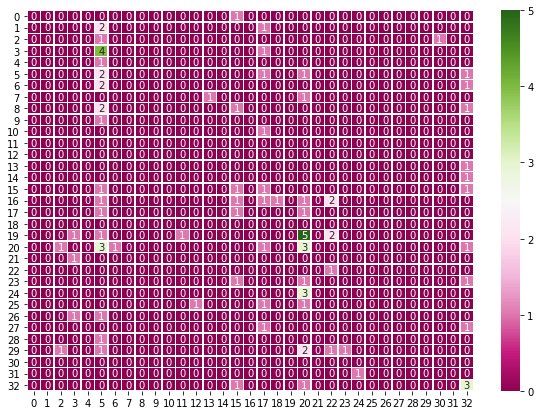

In [143]:
plt.figure(figsize = (10,7))
matrix = sns.heatmap(conf_mtrx, annot=True, fmt=".0f", linewidths=.5, cmap="PiYG") #Making a Heatmap out of the matrix
plt.show()

In [144]:
class_report = classification_report(y_test, preds)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classif

In [145]:
print(class_report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00         3
        12.0       0.00      0.00      0.00         2
        22.0       0.00      0.00      0.00         5
        23.0       0.00      0.00      0.00         1
        24.0       0.08      0.40      0.13         5
        25.0       0.00      0.00      0.00         3
        30.0       0.00      0.00      0.00         2
        31.0       0.00      0.00      0.00         4
        33.0       0.00      0.00      0.00         1
        35.0       0.00      0.00      0.00         1
        36.0       0.00      0.00      0.00         0
        39.0       0.00      0.00      0.00         0
        48.0       0.00      0.00      0.00         1
        55.0       0.00      0.00      0.00         1
        69.0       0.14      0.25      0.18         4
        94.0       0.00      0.00      0.00         7
        95.0       0.00    

In [158]:
estimator = rf.estimators_[3]

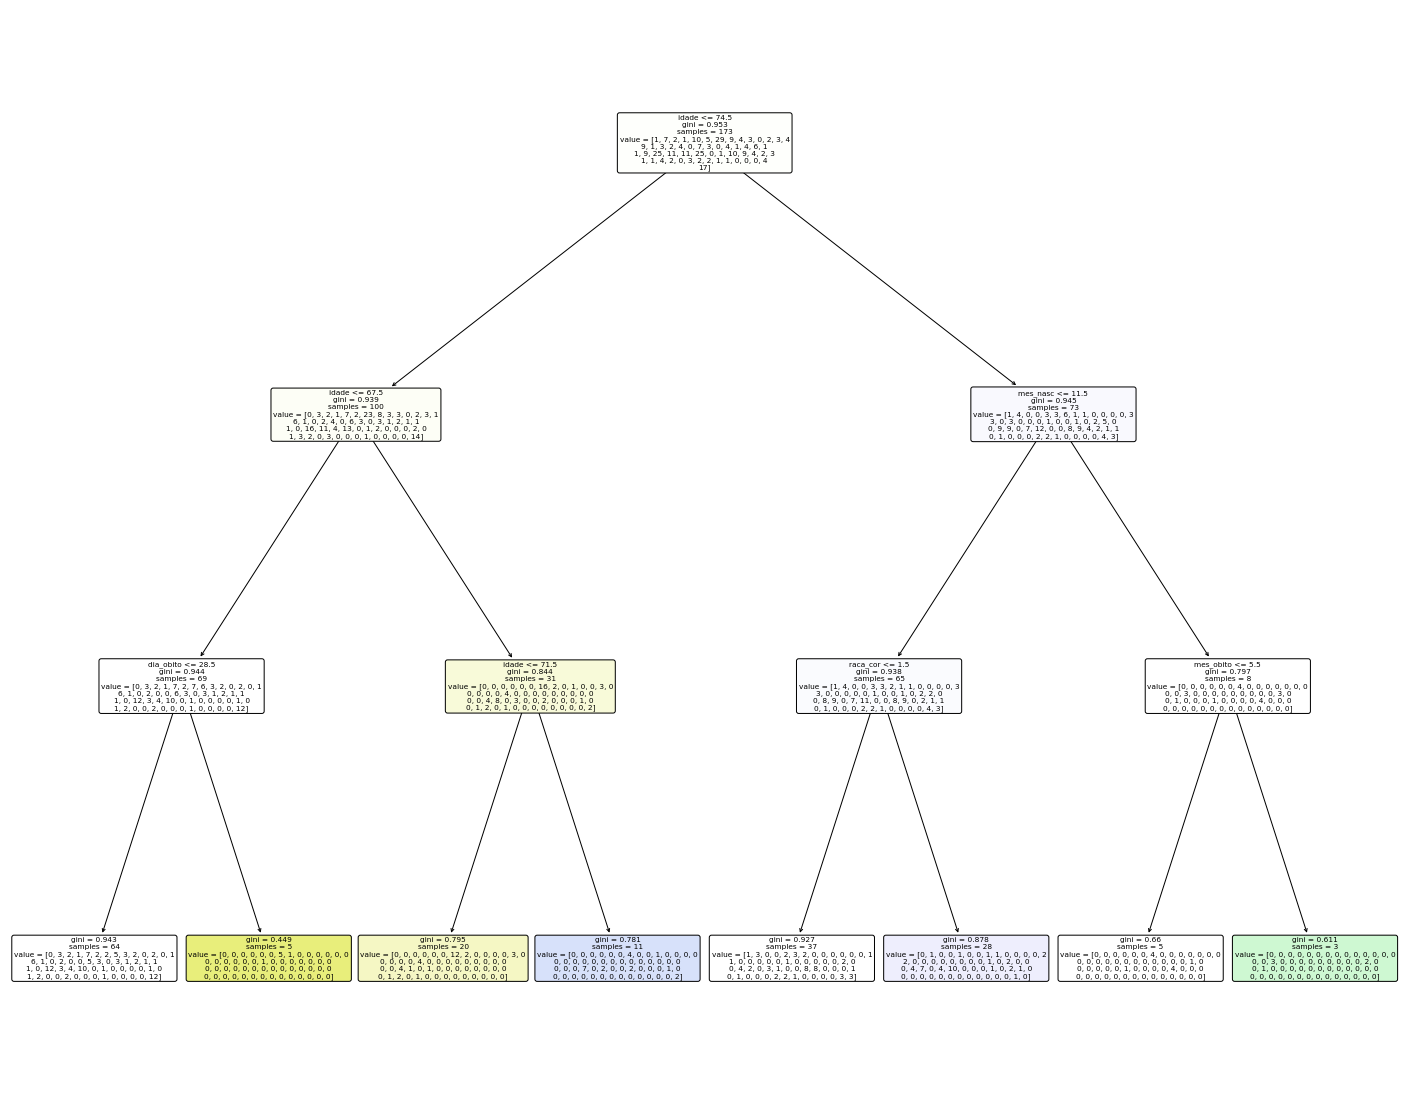

In [162]:
fig = plt.figure(figsize=(25, 20))
plot_tree(rf.estimators_[0], 
          feature_names=x.columns,
          class_names=, 
          filled=True, impurity=True, 
          rounded=True)
plt.show()

In [165]:
fig.savefig('random_forest.png', quality=95, optimizer=True, dpi=100)

<ipython-input-165-888ba775a70a>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('random_forest.png', quality=95, optimizer=True)
<ipython-input-165-888ba775a70a>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimizer" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('random_forest.png', quality=95, optimizer=True)
